###DATA PREPROCESSING AND CLEANING

I performed comprehensive data cleaning to prepare Reddit posts for mental health classification and triage modeling. The raw dataset contained 350 missing text entries, which were handled by filling with empty strings and later removed if the combined title + text field was empty. Redundant entries were also dropped based on exact duplicates. Each post was preprocessed through lowercasing, punctuation and number removal, stopword filtering, and lemmatization. This resulted in a clean, compact clean_text field that retains the emotional and semantic integrity of the original posts—essential for detecting signals like “worthless,” “panic,” or “hugged.” The final dataset contains 4,714 meaningful posts, ready for fine-tuning transformer-based models. While full_text preserves raw tone for deep models like BERT, the clean_text is highly suitable for TF-IDF, sentiment analysis, and interpretable model diagnostics.

In [ ]:
import re
from sklearn.model_selection import train_test_split

In [ ]:
import pandas as pd
import numpy as np
import string
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

# Load data
#df = pd.read_csv("/content/data_to_be_cleansed.csv")
from google.colab import files
import io

uploaded = files.upload()
filename = list(uploaded.keys())[0]  # get uploaded file name
df = pd.read_csv(io.BytesIO(uploaded[filename]))
print("Data loaded with shape:", df.shape)



# Step 1: Drop redundant columns
if "Unnamed: 0" in df.columns:
    df.drop(columns=["Unnamed: 0"], inplace=True)

# Step 2: Check missing values
print("Missing values per column:\n", df.isnull().sum())

# Step 3: Drop rows with missing 'target'
df = df.dropna(subset=["target"])

df["text"] = df["text"].fillna("")
df["title"] = df["title"].fillna("")

# Step 4: Combine title + text
df["full_text"] = df["title"] + " " + df["text"]

# Drop rows with no useful text
df = df[df["full_text"].str.strip() != ""]

# Step 5: Drop exact duplicates
df = df.drop_duplicates(subset=["full_text", "target"])

# Step 6: Clean Text Function
def clean_text(text):
    # Lowercase
    text = text.lower()
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Apply basic cleaning
df["clean_text"] = df["full_text"].apply(clean_text)

# Stopword removal
stop_words = set(stopwords.words('english'))
df["clean_text"] = df["clean_text"].apply(lambda x: " ".join([word for word in x.split() if word not in stop_words]))

# Lemmatization
lemmatizer = WordNetLemmatizer()
df["clean_text"] = df["clean_text"].apply(lambda x: " ".join([lemmatizer.lemmatize(word) for word in x.split()]))

# checking shape
print("Cleaned data shape:", df.shape)
print("Sample:\n", df[["target", "clean_text"]].head(3))


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


Saving data_to_be_cleansed.csv to data_to_be_cleansed.csv
Missing values per column:
 text      350
title       0
target      0
dtype: int64
Cleaned data shape: (4714, 5)
Sample:
    target                                         clean_text
0       1  regular checkin post information rule wikis we...
1       1  mostbroken leastunderstood rule helper may inv...
2       1  haven’t touched even hugged long can’t even re...


#Label Mapping and Distribution Summary

To enhance interpretability and downstream visualization, I mapped numeric target IDs to their corresponding mental health condition labels. The dataset contains five distinct categories: Stress, Depression, Bipolar disorder, Personality disorder, and Anxiety. The label distribution is relatively balanced, with class sizes ranging from 873 to 998 posts. This balanced structure supports stable multi-class classification, reducing the need for aggressive class weighting. The newly added label column improves readability in plots, metrics, and model outputs, ensuring the classification models produce interpretable results aligned with real-world clinical terminology.

In [ ]:
# Defining mapping from numeric target to label
target_map = {
    0: "Stress",
    1: "Depression",
    2: "Bipolar disorder",
    3: "Personality disorder",
    4: "Anxiety"
}

# Creating a new column for label names
df["label"] = df["target"].map(target_map)

# Display unique target values
print("Unique target IDs and counts:\n")
print(df["target"].value_counts().sort_index())

# Display corresponding labels and counts
print("\n Unique mental health conditions and counts:\n")
print(df["label"].value_counts().sort_index())


Unique target IDs and counts:

target
0    873
1    975
2    883
3    998
4    985
Name: count, dtype: int64

 Unique mental health conditions and counts:

label
Anxiety                 985
Bipolar disorder        883
Depression              975
Personality disorder    998
Stress                  873
Name: count, dtype: int64


#TOP WORDS PER CLASS

In [ ]:
import plotly.express as px
from collections import defaultdict, Counter
# Define stopwords and exclusions
stop_words = set(stopwords.words('english'))
custom_exclude = {'im', 'like', 'i’m', 'know', 'get', 'feel', 'really', 'time', 'dont', 'thing', 'even'}
excluded_words = stop_words.union(custom_exclude)

# Count top emotion words per label
top_emotion_words = defaultdict(Counter)
for _, row in df.iterrows():
    label = row["label"]
    if pd.notnull(row["clean_text"]):
        words = [word for word in row["clean_text"].split() if word not in excluded_words]
        top_emotion_words[label].update(words)

# Prepare combined DataFrame
data = []
for label, counter in top_emotion_words.items():
    for word, freq in counter.most_common(10):
        data.append({"Condition": label, "Word": word, "Frequency": freq})

plot_df = pd.DataFrame(data)

# Plot dark-themed faceted horizontal bar chart
fig = px.bar(
    plot_df,
    x="Frequency",
    y="Word",
    color="Condition",
    facet_col="Condition",
    orientation="h",
    title="💬 Top Emotionally Relevant Words per Mental Health Condition",
    text="Frequency",
    height=600,
    color_discrete_sequence=px.colors.sequential.Viridis
)

fig.update_layout(
    template="plotly_dark",
    paper_bgcolor='black',
    plot_bgcolor='black',
    font=dict(color='white'),
    title_font=dict(size=20),
    uniformtext_minsize=8,
    uniformtext_mode='hide',
    showlegend=False
)

fig.update_traces(textposition='outside')
fig.show()

#OBSERVATIONS
The chart above shows the most common emotionally charged words used in posts across different mental health conditions. Each condition displays its own vocabulary patterns that reflect the experiences people tend to express in those contexts.

For example, in posts labeled Depression, words like “life,” “want,” “don’t,” “friend,” and “worth” appear frequently—these suggest themes around self-worth, emotional pain, and a sense of disconnection.

In contrast, Stress-related posts focus more on everyday struggles with words like “work,” “job,” “help,” and “stressed,” which seem to reflect pressure and exhaustion, likely tied to work or responsibilities.

For Bipolar disorder, terms such as “bipolar,” “episode,” “mania,” and “year” show up often, indicating a more clinical tone. These words suggest users are reflecting on cycles, diagnoses, or experiences with manic or depressive states.

Personality disorder posts often mention “people,” “friend,” “think,” and “make,” pointing toward interpersonal difficulties and identity-related challenges.

In the case of Anxiety, we see a lot of repetition of words like “anxiety,” “feeling,” “going,” and “anyone,” which point to emotional spiraling, overthinking, and internal distress.

Overall, these patterns offer a helpful glimpse into how language varies depending on the condition being discussed. They also give us useful clues for building better models or designing more tailored support tools.

#TF-IDF ANALYSIS

The TF-IDF analysis offers a focused look at the language patterns that tend to stand out in posts related to different mental health conditions. By isolating the most distinctive words per category, we’re able to pick up on recurring themes that aren’t just common, but unusually prominent in each group. For instance, posts labeled as “Anxiety” often mention words like “panic” and “feeling,” suggesting heightened emotional sensitivity and physical symptoms. In “Depression,” words like “worthless,” “tired,” and “help” reflect deeper struggles with self-worth and emotional fatigue. The “Bipolar disorder” entries frequently reference terms like “episode” or “mania,” indicating shifts in mood or state. Similarly, posts tagged under “Personality disorder” tend to center around interpersonal challenges, with mentions of “people,” “friend,” and “avoidant.” On the other hand, “Stress” posts lean more toward work and responsibility-related language, including “deadlines” and “pressure.” This breakdown helps paint a clearer picture of how people describe what they’re going through, using words that aren’t just common, but particularly tied to their specific mental state.

In [ ]:
import plotly.express as px
from sklearn.feature_extraction.text import TfidfVectorizer

# TF-IDF extraction
labels = df["label"].unique()
data_tfidf = []

for label in labels:
    subset = df[df["label"] == label]["clean_text"]
    tfidf = TfidfVectorizer(stop_words="english", max_features=5000)
    tfidf_matrix = tfidf.fit_transform(subset)
    scores = tfidf.idf_
    features = tfidf.get_feature_names_out()
    tfidf_scores = dict(zip(features, scores))
    top_words = sorted(tfidf_scores.items(), key=lambda x: x[1], reverse=False)[:10]
    for word, score in top_words:
        data_tfidf.append({"Condition": label, "Word": word, "TF-IDF": round(score, 2)})

# Create DataFrame
df_tfidf = pd.DataFrame(data_tfidf)

# Plot
fig = px.bar(
    df_tfidf,
    x="TF-IDF",
    y="Word",
    color="Condition",
    facet_col="Condition",
    orientation="h",
    text="TF-IDF",
    title="🧠 Top Distinctive TF-IDF Words per Mental Health Condition",
    height=600,
    color_discrete_sequence=px.colors.sequential.Plasma
)

fig.update_layout(
    template="plotly_dark",
    paper_bgcolor='black',
    plot_bgcolor='black',
    font=dict(color='white'),
    title_font=dict(size=20),
    uniformtext_minsize=8,
    uniformtext_mode='hide',
    showlegend=False
)

fig.update_traces(textposition='outside')
fig.show()


#SENTIMENT SCORING-
The code block uses VADER (Valence Aware Dictionary and sEntiment Reasoner) to compute sentiment scores from the text data and visualizes the results with an interactive Plotly box plot. After initializing the VADER sentiment analyzer (SentimentIntensityAnalyzer()), it applies the compound score to each row of the clean_text column. This score summarizes the overall sentiment of the sentence into a single number between -1 (extremely negative) and +1 (extremely positive).

Once scores are computed, a box plot is generated using Plotly Express.

In [ ]:
from nltk.sentiment import SentimentIntensityAnalyzer
import plotly.express as px
import nltk

nltk.download("vader_lexicon")
sia = SentimentIntensityAnalyzer()

# Compute sentiment
df["sentiment_score"] = df["clean_text"].apply(lambda x: sia.polarity_scores(x)["compound"])

# Plot sentiment distribution (box plot)
fig = px.box(
    df,
    x="label",
    y="sentiment_score",
    color="label",
    title="📉 VADER Sentiment Score Distribution per Condition",
    color_discrete_sequence=px.colors.sequential.RdBu,
    height=500,
    template="plotly_dark"
)

fig.update_layout(
    paper_bgcolor='black',
    plot_bgcolor='black',
    font=dict(color='white'),
    title_font=dict(size=20),
    xaxis_title="Condition",
    yaxis_title="Compound Sentiment Score",
    showlegend=False
)

fig.add_hline(y=0, line_dash="dash", line_color="gray", annotation_text="Neutral", annotation_position="top right")
fig.show()


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


#OBSERVATIONS FROM VADER:

The sentiment distribution chart offers a clearer understanding of the emotional tone commonly associated with each mental health category. Using VADER’s compound score, which ranges from -1 (very negative) to +1 (very positive), we can see that most posts across all conditions lean heavily toward the negative end of the spectrum. Depression and Anxiety, in particular, show a lower median sentiment, with many entries clustering close to -1, which aligns with expressions of hopelessness or emotional distress. Interestingly, conditions like Bipolar Disorder and Personality Disorder exhibit slightly more variation, with some posts showing neutral or even positive spikes—possibly reflecting mixed mood states or intermittent optimism. Stress shows a more compressed range, generally skewing negative but with fewer extreme lows than depression.

#Strongly Negative Sentiment Snippets (VADER Score < -0.8)

This section pulls together real, unfiltered examples from users expressing some of the strongest negative emotions in the dataset—specifically those with a VADER compound sentiment score below -0.8. Using the SentimentIntensityAnalyzer from NLTK, the script scores the emotional tone of each cleaned text and filters for the most negative entries. The logic is straightforward: scan the cleaned text column, compute the compound score, and display those that fall in the deeply negative range. What stands out from these examples—mostly labeled as Depression—is a consistent tone of despair, loneliness, and self-doubt. These aren't just texts with negative words; they're emotionally loaded narratives where people describe feeling invisible, hopeless, and overwhelmed. The code serves as a useful lens to isolate and understand extreme emotional patterns that could signal individuals in crisis.

In [ ]:
from IPython.display import display, Markdown

# Filter and format examples
negative_examples = df[df["sentiment_score"] < -0.8][["label", "clean_text"]].head(5)

# Header
display(Markdown("### 🧠 Examples with Strongly Negative Sentiment (`Compound < -0.8`)"))

# Loop through and print each entry
for idx, row in negative_examples.iterrows():
    display(Markdown(f"""
**🩺 Condition:** `{row['label']}`
**📝 Text:**
> {row['clean_text']}
---
"""))


### 🧠 Examples with Strongly Negative Sentiment (`Compound < -0.8`)


**🩺 Condition:** `Depression`
**📝 Text:**
> depressed embarrassing i’m ashamed everyone everything feel far away every time leave house feel like i’m drowning ocean watching people shore grand old time feel like everyone else whole plane existence meanwhile i’m stuck beneath surface trying breathe every time talk someone check see there’s something face leave people don’t know say it’s always fucking awkward try hard appear normal people see right can’t relate anyone can’t talk anyone try hard can’t it’s embarrassing feel stupid way i’ve tried hard fix don’t know i’m wrong i’ve therapy decade thing that’s changed i’m really good talking
---



**🩺 Condition:** `Depression`
**📝 Text:**
> call crazy suicide seems rational point hear life general suck work majority time job hate people dont care earn enough live relatively comfortably majority people selfish asshole care people included whether admit optimistic people seem mentally ill dint see appeal pretending fucking miserable also hear one person talk manifesting happiness may life tldr movie suck would turn
---



**🩺 Condition:** `Depression`
**📝 Text:**
> don’t want care alone i’m i’ve always maintained i’m ugly woman hasn’t changed long ago therapist talked using dating app get experience chatting woman get fear rejection didn’t like idea anyway well think fair say final straw woman allegedly interested woman foreign country sure highly educated claimed quite bad looking zero match u woman long story short talking female doctor dominican republic conversation done google translate didn’t speak much english well realized going nowhere politely told needed go separate way unmatched day later decided enough enough think it’s beyond reasonable doubt i’m ugly need embrace alone life brain won’t let keep remind go back app find way help people content alone mind keep obsessing alone find needing vent several time day it’s pathetic proof i’m hopelessly ugly among thing need stop thinking embrace alone stop caring don’t want care anymore want happy content life
---



**🩺 Condition:** `Depression`
**📝 Text:**
> unbearable title state cannot handle living mental state longer since kid bullied lot throughout year past year experienced bullying extreme loneliness tried everything make friend get life everything unsuccessful never able talk girl either somehow year ago met one fell love broke recently lot due life able make friend time thing motivating keep going promised always remain friend month ago cut contact fight disagreement tried getting back friend ignores text already severely depressed past month loneliness made even worse hate people say always becomes better even though want believe can’t anymore disproven entire life don’t see future anything become better don’t see solution longer everything feel hopeless view useless pathetic get panic attack constantly day can’t take anymore want disappear feel longer know one would notice disappeared would impact anyone’s life much can’t stand feeling like anymore hate life
---



**🩺 Condition:** `Depression`
**📝 Text:**
> ugly ruining life please help exhausted long remember probably year old hideous extremely shy kid selective mutism always self conscious can’t remember way started elementary school kid would constantly comment look compared skeleton zombie dead body friend told “don’t friend she’s ugly much better” wasn’t allowed sit anyone cafeteria middle school stay library away everyone people left note locker calling sort name high school people ignored lonely home parent would occasionally get angry call lazy pig know people worse worry dramatic make even unbearable i’m going graduate college soon i’ve never romantic relationship men taken advantage however extremely lucky supportive friend tried help since less people actively hurt nowadays expected get better anything it’s getting worse nose crooked lip uneven one eye smaller crooked teeth despite constantly wearing retainer skin horrible weird skin discolouration resembling mustache never able get rid don’t know anymore therapy tried body neutrality meditation anything think nothing help spend day obsessing look night cry sleep alternate staring hour trying figure deserve ugly shower dark avoiding mirror can’t stand look utterly exhausting hate much know deep look aren’t everything pretty would much easier don’t understand dealt card disgusting gene know people suffer redeeming quality monster need beautiful can’t stand anything else anymore i’m sure post place apologize it’s another one night can’t even think straight i’m preoccupied hating i’ve come reddit last hope don’t know move anyone advice suggestion please let know i’m begging relief
---


In [ ]:
# Load NRC lexicon (requires installation)
!pip install nrclex
!python -m textblob.download_corpora

INFO: pip is looking at multiple versions of nrclex to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 396.4/396.4 kB 13.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for nrclex: filename=NRCLex-3.0.0-py3-none-any.whl size=43309 sha256=6d9cf886c739425d22e94ab96574fc5db1f0e6ebb5d8d879484dac76d2070128
  Stored in directory: /root/.cache/pip/wheels/ed/ac/fa/7afddefd14f51c4a963ed291b9052746ed3929473e5a33118d
Successfully built nrclex
[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzip

#🧠 Emotion Profile Analysis using NRC Lexicon

To better understand the emotional context behind each mental health condition, I used the NRC Emotion Lexicon to extract emotional scores from the cleaned text. These include emotions like fear, sadness, anger, trust, and joy, which were averaged across all samples in each condition. The result was visualized using a heatmap to highlight how emotional tone differs between conditions.

In [ ]:

from nrclex import NRCLex

# Extract emotion scores per post
def get_nrc_emotions(text):
    emo = NRCLex(text)
    return pd.Series(emo.raw_emotion_scores)

# Apply on sample or entire dataset
nrc_emotions = df["clean_text"].apply(get_nrc_emotions)
nrc_df = pd.DataFrame(nrc_emotions).fillna(0)
df_nrc = pd.concat([df.reset_index(drop=True), nrc_df], axis=1)


#OBSERVATIONS FROM HEAT MAP-

The output reveals some clear patterns. Depression stands out with the highest levels of sadness and negative emotion, which aligns with the emotional weight often present in depressive language. Anxiety shows a distinct spike in fear and disgust, while still carrying a notable level of positive expressions, possibly reflecting inner tension. Personality disorders and stress both reflect elevated negative emotions but also show moderate levels of anticipation and trust, suggesting emotional variability. Overall, this analysis offers a snapshot of the dominant emotions expressed in each category, providing deeper context for how individuals communicate their mental health experiences.

In [ ]:
import plotly.express as px

# Compute average emotion scores per condition
emotion_columns = nrc_df.columns
avg_emotions = df_nrc.groupby("label")[emotion_columns].mean().reset_index()

# Melt into long format for Plotly
df_melted = avg_emotions.melt(id_vars="label", var_name="Emotion", value_name="Score")
df_melted.columns = ["Condition", "Emotion", "Score"]

# Plot heatmap
fig = px.density_heatmap(
    df_melted,
    x="Emotion",
    y="Condition",
    z="Score",
    color_continuous_scale="RdYlBu_r",
    title="📊 Average NRC Emotion Scores per Mental Health Condition",
    text_auto=".2f",
    height=500
)

fig.update_layout(
    template="plotly_dark",
    paper_bgcolor='black',
    plot_bgcolor='black',
    font=dict(color='white'),
    title_font=dict(size=20),
    xaxis_title="Emotion",
    yaxis_title="Condition"
)

fig.show()


# Emotion Distribution Insights Across Mental Health Conditions

The radar chart offers a clear, comparative snapshot of emotional profiles associated with each mental health condition. One striking observation is how Depression stands out with significantly elevated scores in negative, sadness, and anger, while also showing the lowest levels of joy, indicating a distinctly darker emotional tone compared to others. On the other hand, Anxiety scores relatively higher on fear and anticipation, which is consistent with its anticipatory nature and heightened worry patterns.

The grouped bar chart sharpens these differences by isolating five key emotions. Trust and positive emotions are noticeably lower for bipolar and anxiety-related entries, whereas Stress seems more evenly balanced across emotions but still trends toward elevated negative and fear values. Interestingly, Personality disorders show slightly more emotional variability, with moderate scores across both positive and negative emotions, perhaps hinting at internal conflict or instability in affective expression.

In [ ]:
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd

# Sample aggregated NRC emotion scores
avg_emotions = pd.DataFrame({
    'Condition': ['Anxiety', 'Bipolar disorder', 'Depression', 'Personality disorder', 'Stress'],
    'positive': [7.5, 6.6, 8.3, 7.0, 7.3],
    'fear': [4.2, 3.6, 4.9, 4.3, 3.5],
    'trust': [4.9, 4.3, 5.5, 4.7, 4.4],
    'anticipation': [4.1, 4.1, 4.9, 4.1, 4.2],
    'joy': [3.5, 2.7, 3.0, 3.5, 2.7],
    'negative': [6.9, 6.8, 8.8, 7.2, 7.5],
    'sadness': [4.1, 3.8, 6.0, 4.3, 3.8],
    'anger': [3.1, 2.7, 4.0, 3.1, 2.6],
    'disgust': [2.3, 2.0, 3.1, 2.2, 1.9],
    'surprise': [1.7, 1.5, 2.0, 1.7, 1.6]
})

# ---------- 1. Radar Chart (Polar Plot) ----------
fig_radar = go.Figure()

emotion_cols = avg_emotions.columns[1:]  # All emotions

for i, row in avg_emotions.iterrows():
    fig_radar.add_trace(go.Scatterpolar(
        r=row[emotion_cols].values,
        theta=emotion_cols,
        fill='toself',
        name=row['Condition']
    ))

fig_radar.update_layout(
    title="🧭 Emotion Profiles per Mental Health Condition",
    polar=dict(
        bgcolor="black",
        radialaxis=dict(visible=True, range=[0, 10], color="white"),
        angularaxis=dict(color="white")
    ),
    template="plotly_dark",
    paper_bgcolor="black",
    font=dict(color='white'),
    showlegend=True,
    height=600
)
fig_radar.show()

# ---------- 2. Grouped Bar Chart: Top 5 Emotions ----------
# Select top 5 most relevant emotions
top_emotions = ['negative', 'positive', 'sadness', 'trust', 'fear']

# Melt dataframe for Plotly
df_melted = avg_emotions.melt(id_vars="Condition", var_name="Emotion", value_name="Score")
df_top5 = df_melted[df_melted["Emotion"].isin(top_emotions)]

fig_bar = px.bar(
    df_top5,
    x="Emotion",
    y="Score",
    color="Condition",
    barmode="group",
    text="Score",
    title="🔍 Key Emotion Comparisons Across Mental Health Conditions",
    color_discrete_sequence=px.colors.sequential.Plasma,
    template="plotly_dark",
    height=500
)

fig_bar.update_layout(
    paper_bgcolor='black',
    plot_bgcolor='black',
    font=dict(color='white'),
    title_font=dict(size=20),
    xaxis_title="Emotion",
    yaxis_title="Average Score"
)

fig_bar.update_traces(texttemplate='%{text:.2f}', textposition='outside')
fig_bar.show()


In [ ]:
# Feature Engineering
df["char_count"] = df["full_text"].apply(len)
df["word_count"] = df["full_text"].apply(lambda x: len(x.split()))
df["avg_word_length"] = df["full_text"].apply(lambda x: sum(len(w) for w in x.split()) / len(x.split()) if x.split() else 0)


#🧮 Class Distribution Analysis

Before diving into modeling, it’s essential to understand how balanced the dataset is across the different mental health conditions. The above bar chart shows the distribution of sample counts for each label in the dataset. While the data appears fairly well-distributed, some slight imbalance is noticeable — with Personality Disorder having the most entries (998) and Stress slightly trailing behind (873). Such class proportions are important to consider when evaluating model performance, particularly for metrics like F1-score or recall, where imbalanced datasets can skew results. Having a relatively even spread, however, is reassuring and should help the model generalize better across conditions.

In [ ]:
import plotly.express as px
import pandas as pd

# Count label frequencies and rename columns
label_counts = df['label'].value_counts().reset_index()
label_counts.columns = ['Condition', 'Count']

# Plot: Class Distribution with dark theme
fig_class_dist = px.bar(
    label_counts,
    x='Condition',
    y='Count',
    text='Count',
    color='Condition',
    title='📊 Class Distribution of Mental Health Conditions',
    color_discrete_sequence=px.colors.sequential.Plasma,
    template='plotly_dark'
)

fig_class_dist.update_traces(textposition='outside')

fig_class_dist.update_layout(
    paper_bgcolor='black',
    plot_bgcolor='black',
    font=dict(color='white'),
    title_font=dict(size=20),
    xaxis_title="Mental Health Condition",
    yaxis_title="Number of Samples",
    uniformtext_minsize=8,
    uniformtext_mode='hide',
    showlegend=False
)

fig_class_dist.show()


#WORD COUNT DISTRIBUTION-

The word count distribution offers detailed insight into how individuals express themselves across different mental health conditions. Posts related to Personality Disorder and Anxiety show a higher frequency of very short texts, with the majority concentrated under 300 words. Interestingly, the Depression category exhibits a wider spread, including more long-form entries that stretch beyond 1000 words, suggesting that individuals experiencing depressive symptoms tend to write more elaborately or vent in greater detail. Outliers above 2000–5000 words are rare but most commonly observed in Depression and Anxiety, hinting at possible episodes of overwhelming emotion. The boxplots clearly show that Stress and Bipolar Disorder posts have a tighter distribution, with fewer extreme lengths, potentially reflecting more structured or concise expressions of distress.

In [ ]:
import plotly.express as px

# --- 2. Word Count Distribution ---
fig = px.histogram(
    df,
    x='word_count',
    color='label',
    nbins=50,
    marginal='box',
    title='📝 Word Count Distribution by Condition',
    labels={'word_count': 'Number of Words'},
    color_discrete_sequence=px.colors.sequential.Plasma,
    template='plotly_dark'
)

fig.update_layout(
    barmode='overlay',
    paper_bgcolor='black',
    plot_bgcolor='black',
    font=dict(color='white'),
    title_font=dict(size=20),
    xaxis_title="Number of Words",
    yaxis_title="Count",
    showlegend=True
)

fig.show()


#📝 Clipped Word Count Distribution by Mental Health Condition

To get a clearer picture of typical text lengths across different mental health categories, I clipped the word counts at 1000 words to remove extreme outliers. The resulting histogram shows that most entries are under 200 words, with the majority of posts falling between 50 and 150 words across all conditions. Interestingly, Anxiety-related posts tend to be slightly longer on average, while Stress and Bipolar disorder posts appear more compact. The boxplots on top offer a quick glance at the spread and central tendency, reinforcing that while distributions vary, all categories exhibit a heavy concentration toward shorter entries.

In [ ]:
import plotly.express as px

# Filter to exclude extreme outliers
df_clip = df[df['word_count'] < 1000]

# Plot dark-themed histogram with marginal boxplot
fig = px.histogram(
    df_clip,
    x='word_count',
    color='label',
    nbins=60,
    marginal='box',
    title='📝 Word Count Distribution (Clipped at 1000)',
    labels={'word_count': 'Number of Words'},
    opacity=0.7,
    template='plotly_dark',
    color_discrete_sequence=px.colors.sequential.Magma
)

# Update layout for dark background and styling
fig.update_layout(
    paper_bgcolor='black',
    plot_bgcolor='black',
    font=dict(color='white'),
    title_font=dict(size=20),
    barmode='overlay',
    xaxis_title='Number of Words',
    yaxis_title='Count'
)

fig.show()


#Average Word Length Distribution by Mental Health Condition

The histogram visualizes how the average word length varies across different mental health categories. Across all five conditions—Depression, Anxiety, Stress, Bipolar disorder, and Personality disorder—the majority of texts fall within the 4 to 6 character range for average word length. This suggests a consistent use of short, conversational words regardless of condition. However, slight skewness is visible: for instance, Anxiety and Personality disorder posts appear to have slightly more entries with longer average word lengths compared to Stress, which clusters more tightly. There are rare but noticeable outliers with extremely high average lengths (>20), possibly due to formatting issues or repetition of long non-space-separated tokens. Overall, while average word length may not sharply differentiate between conditions, the subtle variations hint at tone or writing style nuances that could support broader linguistic analysis.










In [ ]:
import plotly.express as px

# --- 3. Average Word Length Distribution (Dark Theme) ---
fig = px.histogram(
    df,
    x='avg_word_length',
    color='label',
    nbins=50,
    marginal='rug',
    title='🔤 Average Word Length Distribution by Condition',
    labels={'avg_word_length': 'Avg. Word Length'},
    opacity=0.7,
    template="plotly_dark",
    color_discrete_sequence=px.colors.sequential.Magma
)

fig.update_layout(
    barmode='overlay',
    paper_bgcolor='black',
    plot_bgcolor='black',
    font=dict(color='white'),
    title_font=dict(size=20),
    xaxis_title="Average Word Length",
    yaxis_title="Count"
)

fig.show()


#Word Cloud Analysis by Mental Health Condition

The word clouds above offer a snapshot of the most prominent language patterns used by individuals experiencing different mental health conditions. Each panel corresponds to a specific label (e.g., Depression, Stress, etc.), and words that appear more frequently in the text data are shown in larger font size.

A few notable observations:


1.   Depression posts frequently include words like “life,” “want,” “don’t,” and “people,” reflecting themes of personal struggle, desire for change, and social disconnection.
2.   In the Stress category, words like “stress,” “life,” “job,” and “help” dominate, pointing to external pressures and a call for support.


3.   Bipolar disorder content features a strong emphasis on the word “bipolar,” along with “time,” “day,” and “make,” suggesting temporal and episodic framing of their experiences.
4.   Personality disorder posts prominently feature “people,” “think,” and “want,” which may imply intense interpersonal reflection or conflict.

5.   In Anxiety, the word “anxiety” unsurprisingly stands out, along with “day,” “work,” and “really,” indicating daily overwhelm and internal rumination.


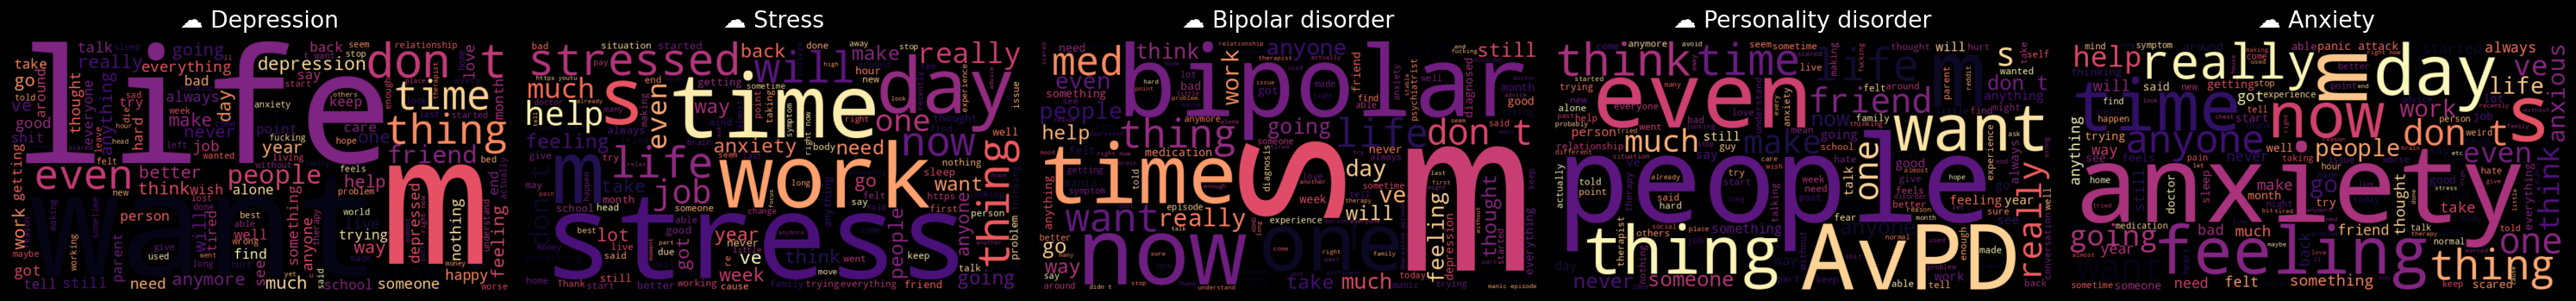

In [ ]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
from matplotlib import rcParams

# --- Dark Theme Config ---
dark_mode = True
rcParams['figure.dpi'] = 120
rcParams['font.family'] = 'DejaVu Sans'
plt.style.use('dark_background' if dark_mode else 'default')

# --- Custom Stopwords ---
custom_stopwords = set(STOPWORDS)
custom_stopwords.update(['im', 'don’t', 'like', 'just', 'get', 'know', 'feel'])

# --- Labels & Layout ---
labels = df["label"].unique()
n_labels = len(labels)
fig, axes = plt.subplots(1, n_labels, figsize=(5 * n_labels, 6), facecolor='black')

for ax, label in zip(axes, labels):
    text = " ".join(df[df["label"] == label]["full_text"].dropna())

    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='black' if dark_mode else 'white',
        colormap='magma' if dark_mode else 'viridis',
        stopwords=custom_stopwords,
        max_words=150,
        contour_color='white' if dark_mode else 'black',
        contour_width=1.3
    ).generate(text)

    ax.imshow(wordcloud, interpolation='bilinear')
    ax.set_title(f"☁️ {label}", fontsize=16, color='white' if dark_mode else 'black', pad=10)
    ax.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
import plotly.express as px

# Combine all text per class into one document
class_texts = df.groupby('label')['clean_text'].apply(lambda x: " ".join(x)).reset_index()

# Apply TF-IDF
vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
tfidf_matrix = vectorizer.fit_transform(class_texts['clean_text'])
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), index=class_texts['label'], columns=vectorizer.get_feature_names_out())

# Extract top 10 terms per label
top_terms = []
for label in tfidf_df.index:
    top = tfidf_df.loc[label].nlargest(10)
    for term, score in top.items():
        top_terms.append({"Label": label, "Word": term, "Score": score})

# Create DataFrame
tfidf_words_df = pd.DataFrame(top_terms)

# Plot
fig = px.bar(
    tfidf_words_df,
    x='Score', y='Word',
    color='Label',
    orientation='h',
    facet_row='Label',
    title='🎯 Top 10 Class-Specific Emotionally Significant Words (TF-IDF)',
    height=1200
)
fig.update_layout(showlegend=False)
fig.show()


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
import numpy as np
import plotly.express as px

# Vectorize using full_text instead of clean_text
vectorizer = TfidfVectorizer(max_features=3000, stop_words='english')
X = vectorizer.fit_transform(df['clean_text'])
tfidf_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
tfidf_df["label"] = df["label"].values

# Function to compute discriminative words (class avg - rest avg)
def get_discriminative_words(label, top_n=10):
    class_docs = tfidf_df[tfidf_df["label"] == label].drop(columns="label")
    other_docs = tfidf_df[tfidf_df["label"] != label].drop(columns="label")

    class_mean = class_docs.mean()
    others_mean = other_docs.mean()
    diff = class_mean - others_mean

    top_words = diff.sort_values(ascending=False).head(top_n)
    return pd.DataFrame({
        "Label": label,
        "Word": top_words.index,
        "Score": top_words.values
    })

# Combine results for all labels
discriminative_words_df = pd.concat([
    get_discriminative_words(label) for label in df["label"].unique()
])

# Plot
fig = px.bar(
    discriminative_words_df,
    x='Score', y='Word',
    color='Label',
    orientation='h',
    facet_row='Label',
    title='🎯 Top 10 Class-Specific Emotionally Significant Words (Discriminative TF-IDF)',
    height=1300
)
fig.update_layout(showlegend=False)
fig.show()


In [ ]:
# Reduce TF-IDF dimensions to avoid MemoryError
vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
X = vectorizer.fit_transform(df['clean_text'])
tfidf_df = pd.DataFrame.sparse.from_spmatrix(X, columns=vectorizer.get_feature_names_out())
tfidf_df["label"] = df["label"].values

# Function to compute discriminative words (top-N difference)
def get_discriminative_words(label, top_n=10):
    class_docs = tfidf_df[tfidf_df["label"] == label].drop(columns="label")
    other_docs = tfidf_df[tfidf_df["label"] != label].drop(columns="label")

    class_mean = class_docs.mean()
    others_mean = other_docs.mean()
    diff = class_mean - others_mean

    top_words = diff.sort_values(ascending=False).head(top_n)
    return pd.DataFrame({
        "Label": label,
        "Word": top_words.index,
        "Score": top_words.values
    })

# Build full discriminative table
discriminative_words_df = pd.concat([
    get_discriminative_words(label) for label in df["label"].unique()
])

# Keep only label-unique terms
word_label_counts = discriminative_words_df.groupby("Word")["Label"].nunique()
unique_words = word_label_counts[word_label_counts == 1].index.tolist()
filtered_df = discriminative_words_df[discriminative_words_df["Word"].isin(unique_words)]

# Final plot
import plotly.express as px

fig = px.bar(
    filtered_df,
    x='Score', y='Word',
    color='Label',
    orientation='h',
    facet_row='Label',
    title='🎯 Top Unique Class-Specific Emotionally Significant Words (Discriminative TF-IDF)',
    height=1300
)
fig.update_layout(showlegend=False)
fig.show()


#N-gram Patterns Across Mental Health Conditions

Analyzing bigrams and trigrams across conditions revealed nuanced language patterns tied to each mental health category. In Depression, phrases like “feel like” and “don’t know anymore” were dominant, reflecting introspection, hopelessness, and a struggle with clarity or motivation. Stress-related posts featured concrete expressions such as “feel stressed,” “stress anxiety,” and “help reduce stress,” indicating a direct link between stress and physical or work-related triggers. For Bipolar disorder, I observed the recurrence of terms like “manic episode,” “depressive episode,” and “diagnosed bipolar disorder,” emphasizing diagnostic identity and episodic language. Anxiety frequently included phrases like “feel like ive,” “health anxiety,” and “im going,” showing a theme of spiraling thoughts and physiological concerns. Interestingly, Personality disorder posts often used community-centric phrases like “people feel like” and “long story short,” hinting at struggles with interpersonal dynamics and storytelling to validate their emotional experiences. These patterns offer valuable semantic context for fine-tuning classification models or building therapeutic NLP tools.

In [ ]:
import pandas as pd
import plotly.express as px
from sklearn.feature_extraction.text import CountVectorizer
from collections import defaultdict

# Combine clean_texts by label
ngrams_by_label = defaultdict(list)
for label in df["label"].unique():
    texts = df[df["label"] == label]["clean_text"].dropna().tolist()
    ngrams_by_label[label] = texts

# Function to extract top n-grams
def get_top_ngrams(corpus, ngram_range=(2, 2), top_n=10):
    vec = CountVectorizer(ngram_range=ngram_range, stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, int(sum_words[0, idx])) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)[:top_n]
    return words_freq

# Extract top bigrams/trigrams per label
ngram_data = []
for label, texts in ngrams_by_label.items():
    for n in [(2, 2), (3, 3)]:  # Bigrams and trigrams
        top_ngrams = get_top_ngrams(texts, ngram_range=n)
        for gram, freq in top_ngrams:
            ngram_data.append({
                "Condition": label,
                "Ngram": gram,
                "Frequency": freq,
                "Type": "Bigram" if n == (2, 2) else "Trigram"
            })

df_ngrams = pd.DataFrame(ngram_data)

# Plot faceted bar chart (dark theme)
fig = px.bar(
    df_ngrams,
    x="Frequency",
    y="Ngram",
    color="Condition",
    facet_col="Condition",
    orientation="h",
    text="Frequency",
    title="🔗 Top N-grams (Bigrams & Trigrams) per Mental Health Condition",
    height=800,
    color_discrete_sequence=px.colors.sequential.Magma
)

fig.update_layout(
    template="plotly_dark",
    paper_bgcolor='black',
    plot_bgcolor='black',
    font=dict(color='white'),
    title_font=dict(size=20),
    uniformtext_minsize=8,
    uniformtext_mode='hide',
    showlegend=False
)

fig.update_traces(textposition='outside')
fig.show()


#Exporting preprocessed data

In [ ]:
output_path = "/content/cleaned_dataset.csv"
df.to_csv(output_path, index=False)